# Intro to Elasticsearch

> ###  Sarah Braden
> ### @ifmoonwascookie

> ### 27 February 2018
> ### DesertPy

In [2]:
from IPython.display import Image

# Elasticsearch is a search engine
Use elasticsearch to:
* make your own personal search tool
* search through logs of data
* search through data scraped from the web
* search through messy data provided by customers

# Elasticsearch has superpowers
* near real-time 
* distributed
* scalable

# What does this mean?

**Near real-time**: there is a slight latency (normally one second) from the time you index a document until the time it becomes searchable.

**Distributed**: a cluster is a collection of one or more nodes (servers) that together holds your entire data.

**Scalable**: we'll get to that in a second

# Data in Elasticsearch

**Index**: an index is a collection of documents that have somewhat similar characteristics. For example, you can have an index for customer data, another index for a product catalog, and yet another index for order data.

**Document**: a document is a basic unit of information that can be indexed. For example, you can have a document for a single customer, another document for a single product, and yet another for a single order. 

# Shards and Replicas

What happens when the size of data on a given index exceeds the hardware limits of a node?

Elasticsearch automagically subdivides the index into multiple pieces called shards.

Sharding is important for two primary reasons:
1. allows you to horizontally split/scale your content volume
2. allows you to distribute and parallelize operations across shards (and nodes) thus increasing performance/throughput

Replicas are just copies of shards. Replicas are important too:
1. provides high availability in case a shard/node fails
2. allows you to scale out your search volume/throughput since searches can be executed on all replicas in parallel

# Install Elasticsearch

1. Install the Java Developer Kit on your system (not the JRE)
2. Install Elasticsearch on your system
3. Run Elasticsearch in the directory with the elasticsearch files:

` $ ./bin/elasticsearch`

[Documentation for installing](https://www.elastic.co/guide/en/elasticsearch/reference/current/install-elasticsearch.html)

# Elasticsearch has a Python API

[Great documentation](https://elasticsearch-py.readthedocs.io/en/master/)

### Installation
Use virtualenv to make a new virtualenv for your project:

`$ mkvirtualenv elasticsearch-project`

Install the elasticsearch package with pip:

`$ pip install elasticsearch`

# Connect to Elasticsearch

In [3]:
import elasticsearch

es = elasticsearch.Elasticsearch([{'host': 'localhost', 'port': 9200}])

# Is Elasticsearch working?

In [4]:
import requests
res = requests.get('http://localhost:9200')
print(res.content)

{
  "name" : "JWYUFIB",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "UbuWrUr-TFW1vHcNmstVvg",
  "version" : {
    "number" : "6.2.2",
    "build_hash" : "10b1edd",
    "build_date" : "2018-02-16T19:01:30.685723Z",
    "build_snapshot" : false,
    "lucene_version" : "7.2.1",
    "minimum_wire_compatibility_version" : "5.6.0",
    "minimum_index_compatibility_version" : "5.0.0"
  },
  "tagline" : "You Know, for Search"
}



# Is it really working?

http://localhost:9200/_cat/health?v

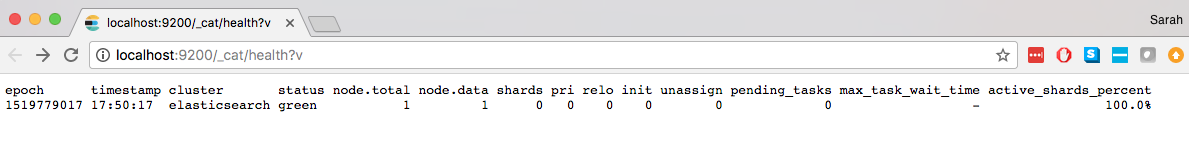

In [5]:
Image("img/cat_v2.png")

# Tangent: What is this cat?

* [cat API](https://www.elastic.co/guide/en/elasticsearch/guide/current/_cat_api.html) is designed to work like `*nix` command-line tools
* cat API is fast in an emergency when you need to diagnose issues with an elasticsearch cluster
* [blog post on cat](https://www.elastic.co/blog/introducing-cat-api)

# What else can cat do?

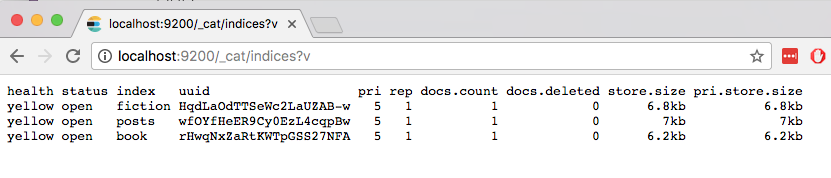

In [6]:
Image("img/cat_indices.png")

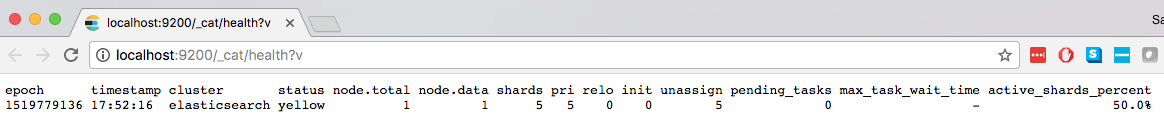

In [7]:
Image("img/cat_one_index.png")

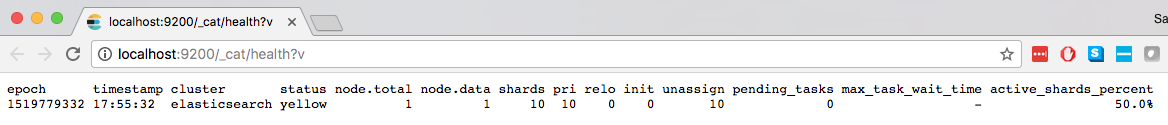

In [8]:
Image("img/cat_10_shards.png")

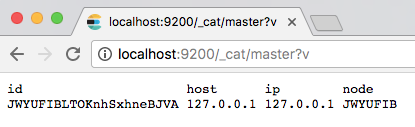

In [9]:
Image("img/cat_master_node.png")

# Let's do some things

## Indexing some test data

In [10]:
es.index(
    index='books',
    doc_type='novel',
    id=1,
    body={
        'author': 'Mary Shelley',
        'title': 'Frankenstein; or, The Modern Prometheus',
        'topics': ['medicine', 'monster', 'frame narrative',
               'alchemy', 'horror'],
        'awesomeness': 0.8
    }
)

{u'_id': u'1',
 u'_index': u'books',
 u'_primary_term': 1,
 u'_seq_no': 2,
 u'_shards': {u'failed': 0, u'successful': 1, u'total': 2},
 u'_type': u'novel',
 u'_version': 1,
 u'result': u'created'}

## Retrieve test data

In [11]:
es.search(
    index="books",
    body={
        "query": {
            "match": {
                'author':'Mary Shelley'
            }
        }
    }
)

{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
 u'hits': {u'hits': [], u'max_score': None, u'total': 0},
 u'timed_out': False,
 u'took': 19}

## Delete test data

In [12]:
es.delete(
    index='books',
    doc_type='novel',
    id=1
)

{u'_id': u'1',
 u'_index': u'books',
 u'_primary_term': 1,
 u'_seq_no': 3,
 u'_shards': {u'failed': 0, u'successful': 1, u'total': 2},
 u'_type': u'novel',
 u'_version': 2,
 u'result': u'deleted'}

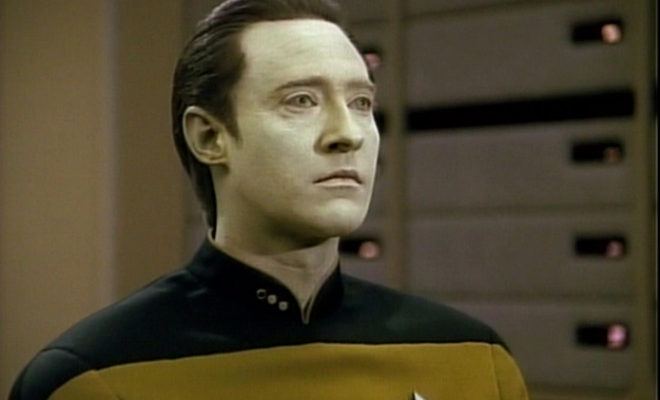

In [13]:
Image("img/Data-Memory-Beta-660x400.jpg")

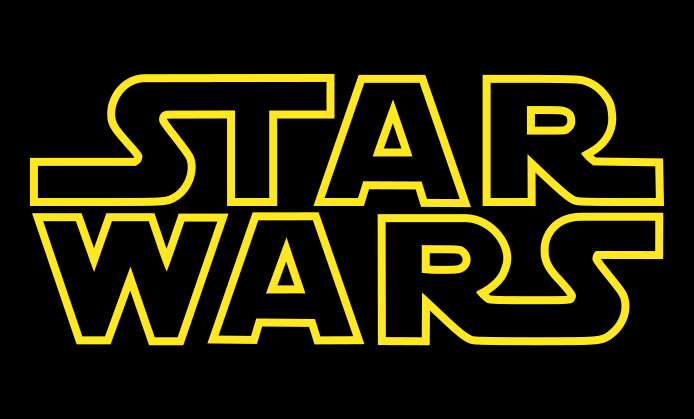

In [14]:
Image("img/694px-Star_Wars_Logo.svg.png")

# SWAPI

https://swapi.co/

## Get Star Wars data
Let's iterate over SWAPI people documents and index them

In [15]:
# es.indices.delete(index='sw')
# es.indices.delete(index='books')

In [16]:
def convert_to_float(content):
    if content['height'] == 'unknown':
        content['height'] = 0.0
    else:
        content['height'] = int(content['height'])
    return content

In [17]:
# Create index
es.indices.create(index='sw')

RequestError: TransportError(400, u'resource_already_exists_exception', u'index [sw/TPGrb3lNS4WESOITKcY84g] already exists')

In [ ]:
# Define a mapping (important for aggregation tasks later)
es.indices.put_mapping(
    index="sw",
    doc_type="people",
    body={
        "properties": {
                "height": {
                    "type": "integer",
            }
        }
    }
)

In [ ]:
import json

r = requests.get('http://localhost:9200') 
i = 1

while r.status_code == 200:
    r = requests.get('http://swapi.co/api/people/'+ str(i))
    es.index(
        index='sw',
        doc_type='people',
        id=i,
        body=convert_to_float(r.json())
    )
    i=i+1

In [ ]:
r = requests.get('http://localhost:9200')
i = 18

while r.status_code == 200:
    r = requests.get('http://swapi.co/api/people/'+ str(i))
    es.index(
        index='sw',
        doc_type='people',
        id=i,
        body=convert_to_float(r.json())
    )
    i=i+1

# How many documents do we have?

In [18]:
es.count()

{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 10, u'total': 10},
 u'count': 87}

## Get the document with id=19

In [19]:
es.get(
    index='sw',
    doc_type='people',
    id=19
)

{u'_id': u'19',
 u'_index': u'sw',
 u'_source': {u'birth_year': u'unknown',
  u'created': u'2014-12-12T11:16:56.569000Z',
  u'edited': u'2014-12-20T21:17:50.343000Z',
  u'eye_color': u'blue',
  u'films': [u'https://swapi.co/api/films/1/'],
  u'gender': u'male',
  u'hair_color': u'brown',
  u'height': 180,
  u'homeworld': u'https://swapi.co/api/planets/26/',
  u'mass': u'110',
  u'name': u'Jek Tono Porkins',
  u'skin_color': u'fair',
  u'species': [u'https://swapi.co/api/species/1/'],
  u'starships': [u'https://swapi.co/api/starships/12/'],
  u'url': u'https://swapi.co/api/people/19/',
  u'vehicles': []},
 u'_type': u'people',
 u'_version': 2,
 u'found': True}

## Search for Darth Vader

In [20]:
result = es.search(
    index="sw",
    body={
        "query": {"match": {
            'name':'Darth Vader'
        }}
    }
)

for hit in result['hits']['hits']:
    print hit['_source']['name']
    print hit['_score']

Darth Vader
5.316138
Darth Maul
2.3211865


This will give us both Darth Vader AND Darth Maul. 
Id 4 and id 44 (notice that they are in the same index, even if we use different node client call the index command).
Both results have a score, although Darth Vader is much higher than Darth Maul (2.77 vs 0.60),
since Vader is a exact match. Take that Darth Maul! 

# Other kinds of queries

### Prefix Query
Useful for autocomplete applications.

In [21]:
result = es.search(
    index="sw", 
    body={
        "query": {"prefix": {
            "name": "lu" 
        }}
    }
)

for hit in result['hits']['hits']:
    print hit['_source']['name']
    print hit['_score']

Luke Skywalker
1.0
Luminara Unduli
1.0


### Multi Match Query
Introduces the concept of fuzzy matching.

In [22]:
es.search(
    index="sw", 
    body={
        "query": {
            "multi_match": { 
                "query": "jaba",
                "fields": ["name", "species"],
                "fuzziness": 1
            }}})

{u'_shards': {u'failed': 0, u'skipped': 0, u'successful': 5, u'total': 5},
 u'hits': {u'hits': [{u'_id': u'16',
    u'_index': u'sw',
    u'_score': 1.6810147,
    u'_source': {u'birth_year': u'600BBY',
     u'created': u'2014-12-10T17:11:31.638000Z',
     u'edited': u'2014-12-20T21:17:50.338000Z',
     u'eye_color': u'orange',
     u'films': [u'https://swapi.co/api/films/4/',
      u'https://swapi.co/api/films/3/',
      u'https://swapi.co/api/films/1/'],
     u'gender': u'hermaphrodite',
     u'hair_color': u'n/a',
     u'height': 175,
     u'homeworld': u'https://swapi.co/api/planets/24/',
     u'mass': u'1,358',
     u'name': u'Jabba Desilijic Tiure',
     u'skin_color': u'green-tan, brown',
     u'species': [u'https://swapi.co/api/species/5/'],
     u'starships': [],
     u'url': u'https://swapi.co/api/people/16/',
     u'vehicles': []},
    u'_type': u'people'}],
  u'max_score': 1.6810147,
  u'total': 1},
 u'timed_out': False,
 u'took': 11}

# Aggregations
Aggregations:
* can help you to analyze your data
* are constructed similar to queries, via a JSON-based DSL (Domain-Specific Language)
* aggregations get appended to a search request, and both the search and aggregation are executed simultaneously

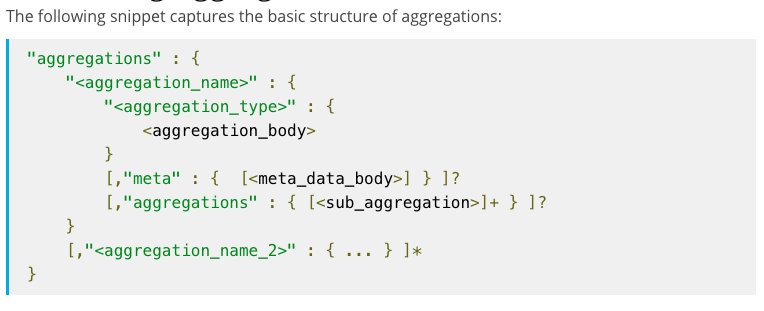

In [23]:
Image("img/aggregation.png")

In [24]:
# Check on your index mapping. Can you aggregate over a certain field?
result = es.indices.get_mapping(index="sw", doc_type="people")

result['sw']['mappings']['people']['properties']['height']

{u'type': u'integer'}

# Simple Aggregation: Average

In [25]:
result = es.search(
    index="sw",
    doc_type="people",
    body={
        "aggs": {
            "average_height": {
                "avg":{
                    "field": "height",
                }
            }
        }
    }
)

result['aggregations']['average_height']

{u'value': 162.33333333333334}

# Resources
* This blog post was helpful: https://bitquabit.com/post/having-fun-python-and-elasticsearch-part-1/
* Blog post using Star Wars API: https://tryolabs.com/blog/2015/02/17/python-elasticsearch-first-steps/